In [ ]:
from google.colab import drive
import os
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# *SHELF LIFE PREDICTION AND  Freshness Detection OF FRUIT SUCH AS APPLE ,CARROT, TOMATO ,BANANA etc...CODE*

In [ ]:
# Uncomment to install specific libraries if needed
!pip install torchvision torch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define dataset path
data_dir = '/content/drive/MyDrive/shelf_life_dataset'

# ImageNet normalization mean and std values
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match EfficientNetV2 input size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Set the seed for reproducibility
torch.manual_seed(42)

# Split dataset into train (80%) and test (20%) sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names to verify correct class mapping
print(full_dataset.classes)  # This should print something like ['Apple(1-5)', 'Apple(6-10)', 'Carrot(1-5)', 'Carrot(6-10)']


['Apple(1-5)', 'Apple(10-14)', 'Apple(5-10)', 'Banana(1-5)', 'Banana(10-15)', 'Banana(15-20)', 'Banana(5-10)', 'Carrot(1-2)', 'Carrot(3-4)', 'Expired', 'Tomato(1-5)', 'Tomato(10-15)', 'Tomato(5-10)', 'carrot(5-6)']


In [ ]:
import torch.nn as nn
from torchvision import models

# Load pre-trained EfficientNetV2 model
model = models.efficientnet_v2_s(pretrained=True)

# Number of classes (based on your dataset structure)
num_classes = len(full_dataset.classes)  # e.g., 4 classes like ['Apple(1-5)', 'Apple(6-10)', 'Carrot(1-5)', 'Carrot(6-10)']

# Modify the final layer to match the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.optim as optim

# CrossEntropyLoss is used for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with learning rate of 0.001
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler to reduce the learning rate over time
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

# Define the training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                data_loader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (track history if only in train phase)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # # Step the scheduler
        # scheduler.step()

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Define the loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

# Example: Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

# Save the complete model after training
torch.save(model, '/content/drive/MyDrive/shelf_life_dataset/model_final1')

# Later, load the model
loaded_model = torch.load('/content/drive/MyDrive/shelf_life_dataset/model_final1')
loaded_model.eval()  # Set to evaluation mode

# Evaluation function
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item() * data.size(0)  # Accumulate loss

            # Get the predicted class by selecting the index of the maximum score
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()  # Count correct predictions
            total += target.size(0)

    # Calculate average loss and accuracy
    avg_loss = test_loss / total
    accuracy = correct / total * 100

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Evaluate the model on the test set
print("Evaluating the loaded model on the test set...")
evaluate(loaded_model, test_loader)

# Optionally, you can evaluate the model again to ensure consistent results
print("Evaluating the loaded model again on the test set...")
evaluate(loaded_model, test_loader)


Epoch 1/25
----------
train Loss: 2.5919 Acc: 0.1385
test Loss: 2.4847 Acc: 0.3127
Epoch 2/25
----------
train Loss: 2.4142 Acc: 0.3372
test Loss: 2.3054 Acc: 0.4832
Epoch 3/25
----------
train Loss: 2.2367 Acc: 0.4576
test Loss: 2.1055 Acc: 0.5168
Epoch 4/25
----------
train Loss: 2.0614 Acc: 0.4958
test Loss: 1.9482 Acc: 0.5633
Epoch 5/25
----------
train Loss: 1.8984 Acc: 0.5152
test Loss: 1.7709 Acc: 0.5736
Epoch 6/25
----------
train Loss: 1.7393 Acc: 0.5366
test Loss: 1.6150 Acc: 0.6124
Epoch 7/25
----------
train Loss: 1.6169 Acc: 0.5489
test Loss: 1.5327 Acc: 0.6253
Epoch 8/25
----------
train Loss: 1.4902 Acc: 0.5696
test Loss: 1.4285 Acc: 0.6227
Epoch 9/25
----------
train Loss: 1.3789 Acc: 0.5896
test Loss: 1.2688 Acc: 0.6589
Epoch 10/25
----------
train Loss: 1.3052 Acc: 0.6129
test Loss: 1.1855 Acc: 0.7106
Epoch 11/25
----------
train Loss: 1.2192 Acc: 0.6434
test Loss: 1.1095 Acc: 0.7209
Epoch 12/25
----------
train Loss: 1.1344 Acc: 0.6660
test Loss: 1.0210 Acc: 0.7623
E

<ipython-input-19-7569e2303d85>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('/content/drive/MyDrive/shelf_life_dataset/model_final1')


Evaluating the loaded model on the test set...
Test Loss: 0.5024, Test Accuracy: 87.34%
Evaluating the loaded model again on the test set...
Test Loss: 0.5076, Test Accuracy: 87.86%


(0.5075933488533478, 87.85529715762273)

In [ ]:
import os
from PIL import Image
import torch

def predict_image(model, image_path, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Return the predicted class
    return full_dataset.classes[predicted.item()]

def predict_images_from_folder(model, folder_path, transform):
    predictions = {}
    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add other image formats if needed
            image_path = os.path.join(folder_path, filename)
            predicted_class = predict_image(model, image_path, transform)
            predictions[filename] = predicted_class

    return predictions

# Example usage
folder_path = '/content/drive/MyDrive/shelf_life_new_data_for_test/shelf_life_new_data_for_test'  # Replace with your folder containing new images
predictions = predict_images_from_folder(model, folder_path, data_transforms)

# Print predictions
for img, pred in predictions.items():
    print(f"Image: {img}, Predicted Class: {pred}")


Image: th (11).jpg, Predicted Class: Apple(10-14)
Image: th (10).jpg, Predicted Class: Expired
Image: th (9).jpg, Predicted Class: Expired
Image: th (8).jpg, Predicted Class: Expired
Image: th (7).jpg, Predicted Class: Carrot(1-2)
Image: th (6).jpg, Predicted Class: Expired
Image: th (5).jpg, Predicted Class: Banana(5-10)
Image: th (4).jpg, Predicted Class: Banana(15-20)
Image: th (3).jpg, Predicted Class: Expired
Image: th (2).jpg, Predicted Class: Apple(10-14)
Image: th (1).jpg, Predicted Class: Apple(10-14)
Image: th.jpg, Predicted Class: Tomato(1-5)


# ***OCR OPTICAL IMAGE RECOGNITION EXPIRY DATES AND OTHER DETAILS ( Brand Detection AND Expiry Date Detection)***

In [ ]:
!pip install torch torchvision opencv-python pytesseract



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,925 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

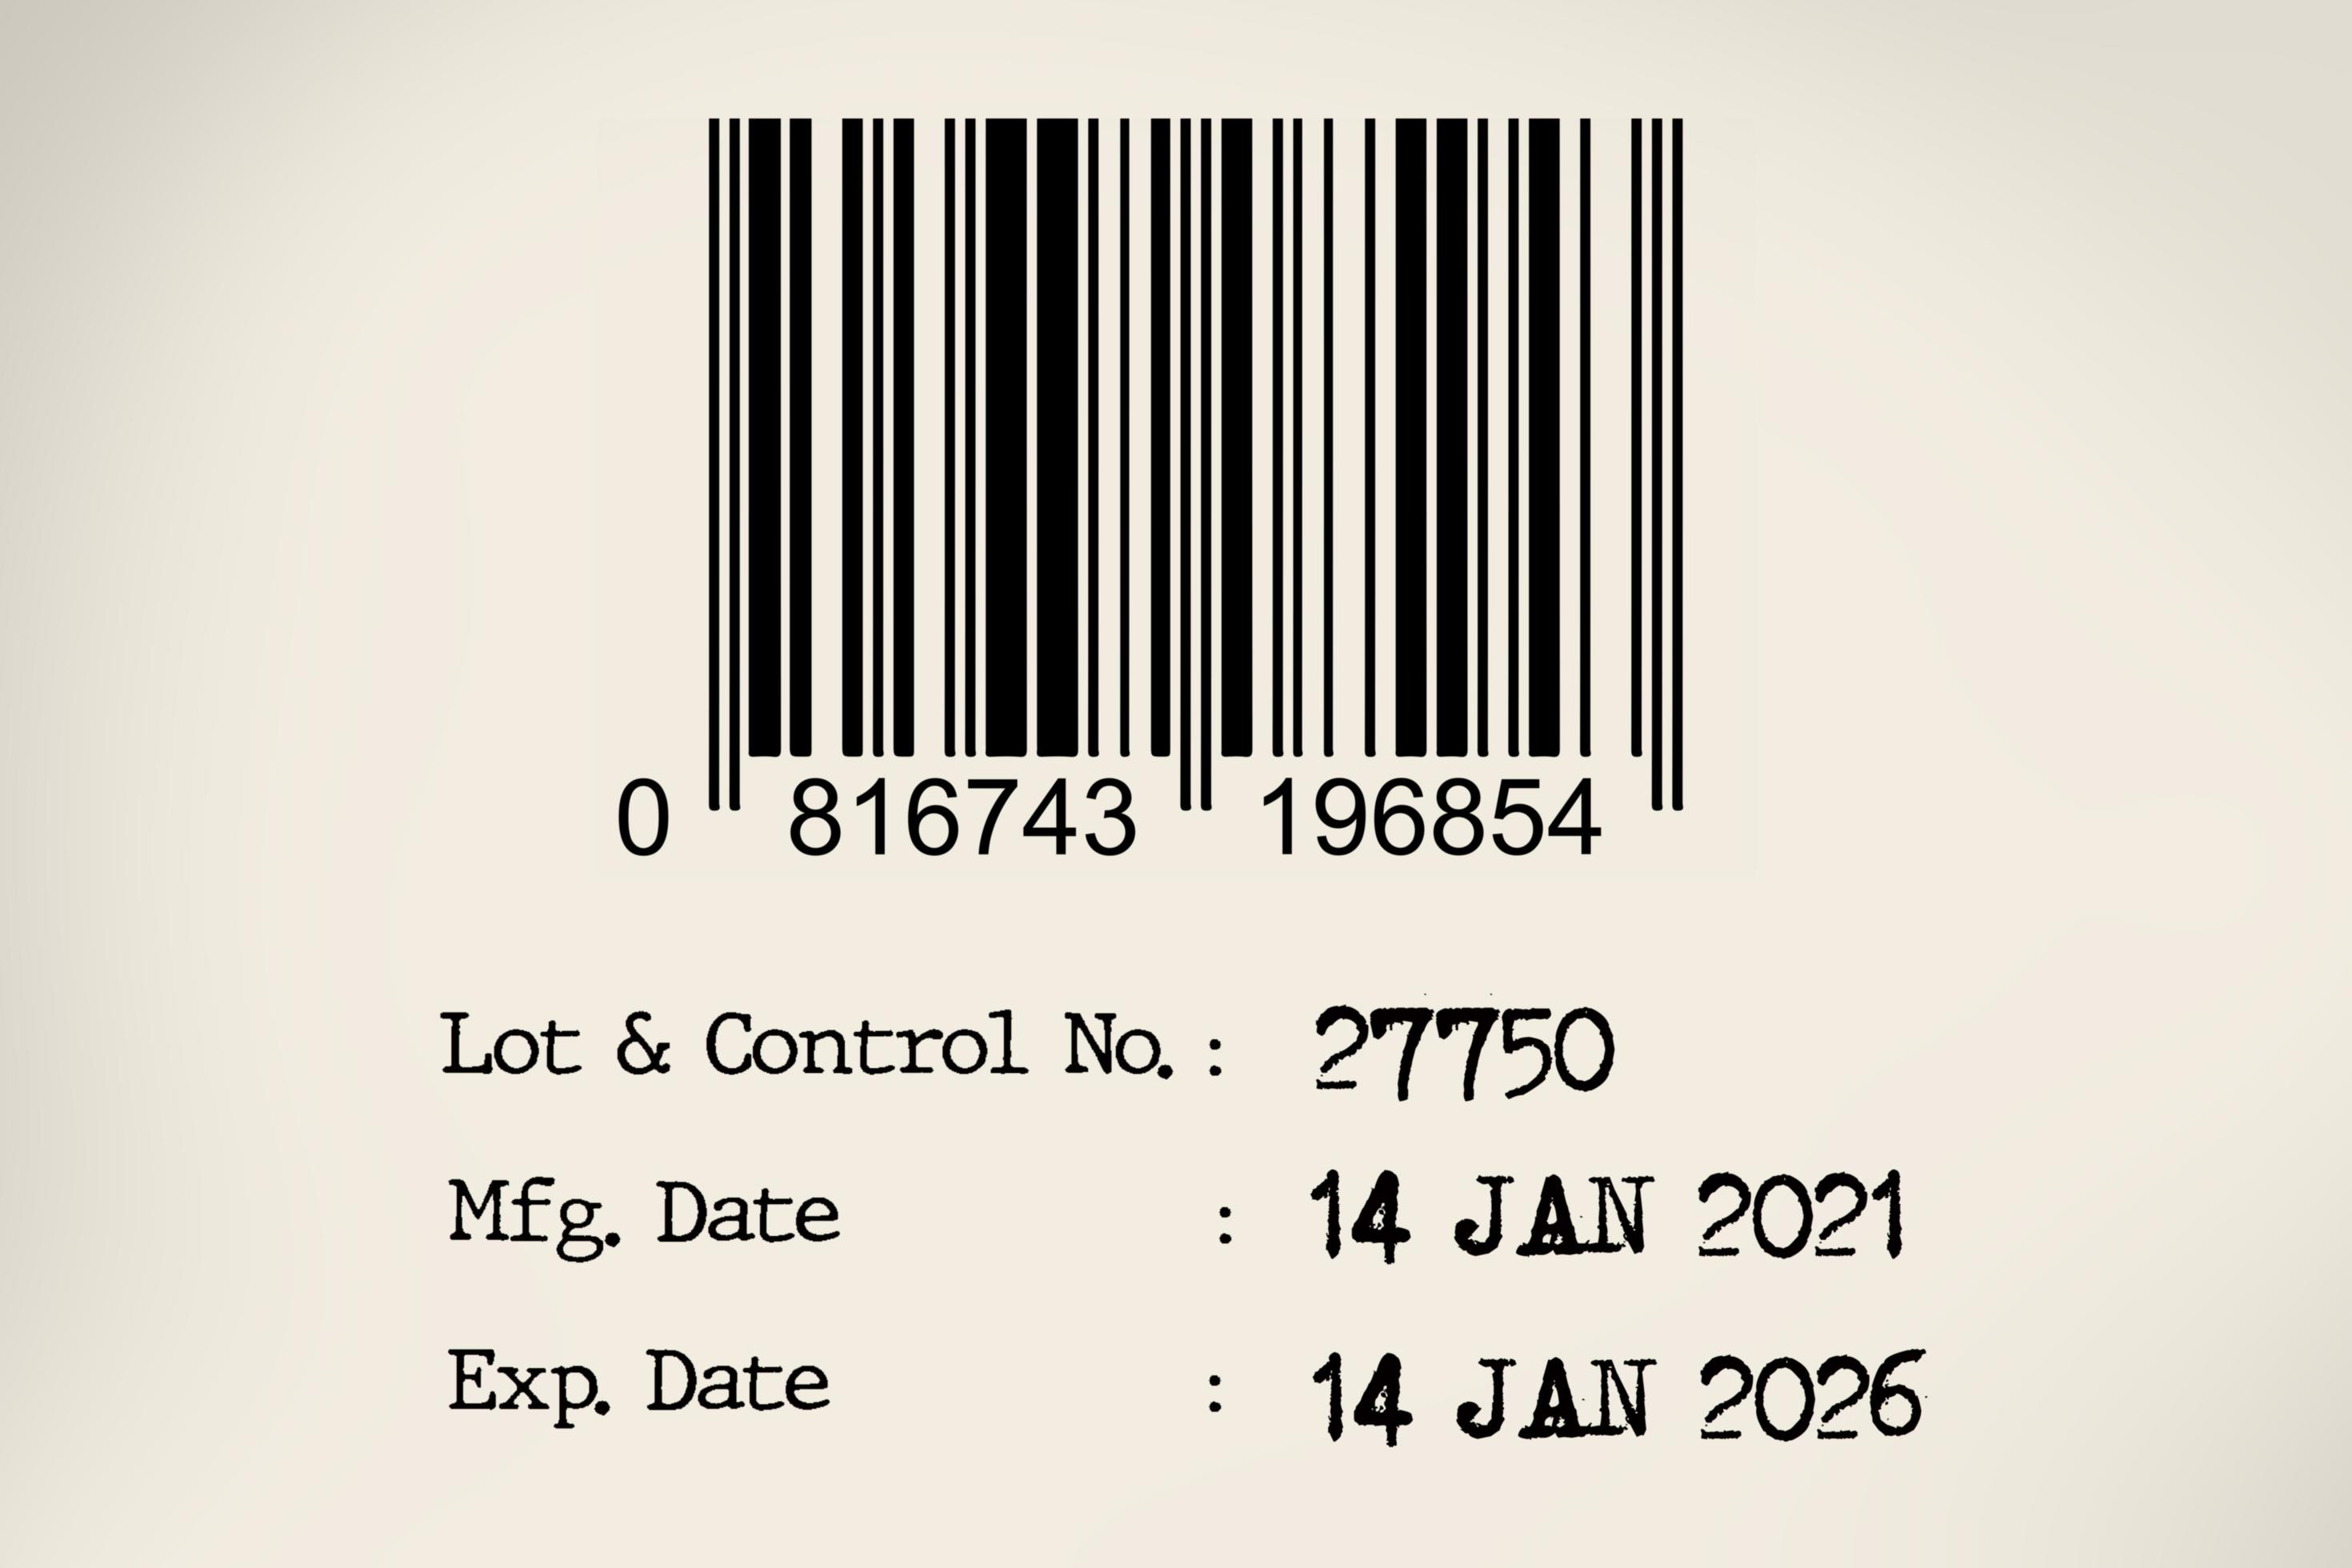

Extracted Text:
 816743 © 196854
Lot & Control No.: 27750
Mfg. Date : 14 JAN 2021
Exp, Date : 14 JAN 2026



In [ ]:
# Install Tesseract OCR
!sudo apt-get install tesseract-ocr

# Install pytesseract wrapper
!pip install pytesseract

# Optional: Check the version to confirm installation
!tesseract --version

# Now set the path to Tesseract executable in pytesseract
import pytesseract

# In Google Colab, tesseract is usually installed in the default location
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Sample code to use OCR on an image
import cv2
from google.colab.patches import cv2_imshow

def ocr_from_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use pytesseract to do OCR
    text = pytesseract.image_to_string(gray)

    # Display the image
    cv2_imshow(img)

    return text

# Test OCR on an example image
image_path = '/content/drive/MyDrive/iloveimg-converted/expiry-date-and-manufacturing-date-with-bar-code-free-photo.jpg'  # Upload the image in Colab
extracted_text = ocr_from_image(image_path)
print("Extracted Text:\n", extracted_text)


In [ ]:
!pip install easyocr



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 24.2 MB/s eta 0:00:00


In [ ]:
import easyocr

# Initialize the reader object
reader = easyocr.Reader(['en'])

# Perform OCR on an image
text = reader.readtext('/content/drive/MyDrive/iloveimg-converted/details-of-expiry-date-and-manufacturing-date-on-product-label-photo.jpg')
# Print recognized text
print(text)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[0, 0], [345, 0], [345, 70], [0, 70]], '', 0.0), ([[1166, 0], [1275, 0], [1275, 60], [1166, 60]], 'U', 0.005024241028551979), ([[1830, 0], [1955, 0], [1955, 57], [1830, 57]], '', 0.0), ([[1985, 0], [2470, 0], [2470, 68], [1985, 68]], '', 0.0), ([[400, 0], [649, 0], [649, 201], [400, 201]], 'W', 0.2391997827121628), ([[1285, 0], [1815, 0], [1815, 136], [1285, 136]], 'Ty0oj ', 0.16022948776319748), ([[337, 144], [485, 144], [485, 328], [337, 328]], '0', 0.9999824763112066), ([[375, 389], [894, 389], [894, 535], [375, 535]], 'Mecteezy', 0.7111871737844985), ([[1272, 406], [1396, 406], [1396, 518], [1272, 518]], 'Doe', 0.0018305532186803516), ([[1445, 405], [1583, 405], [1583, 506], [1445, 506]], 'Wa', 0.17311827694446666), ([[2509, 405], [2940, 405], [2940, 508], [2509, 508]], 'etcite 27', 0.17413763063518803), ([[1206, 510], [1402, 510], [1402, 667], [1206, 667]], 'No_', 0.7926606210468226), ([[1384, 603], [

#***Item Counting using OpenCV and yoloV8 modal***


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 17.0 MB/s eta 0:00:00



0: 640x448 6 donuts, 1 dining table, 192.6ms
Speed: 5.3ms preprocess, 192.6ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 448)
Detected: donut with confidence: 0.96
Detected: donut with confidence: 0.95
Detected: donut with confidence: 0.94
Detected: donut with confidence: 0.93
Detected: donut with confidence: 0.92
Detected: donut with confidence: 0.91
Detected: dining table with confidence: 0.35


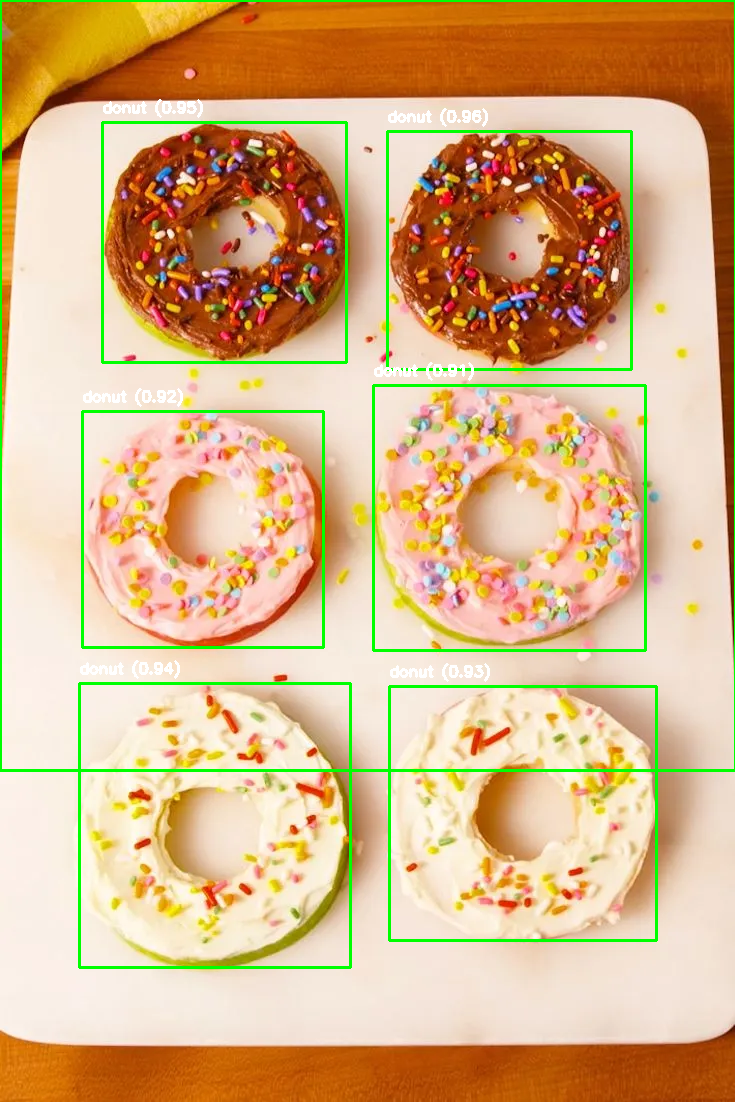

In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # Lightweight YOLOv8 model

# Load the image
image_path = '/content/drive/MyDrive/grid_final/shelf_life_new_data_for_test/shelf_life_new_data_for_test/donut.webp'  # Replace with your image path
image = cv2.imread(image_path)

# Run YOLO detection with a lower confidence threshold
results = model(image, conf=0.25)  # Lower threshold to catch more objects

# Print detected objects
for result in results:
    for box in result.boxes:
        class_id = int(box.cls)
        class_name = model.names[class_id]
        confidence = box.conf[0]
        print(f"Detected: {class_name} with confidence: {confidence:.2f}")

# Draw bounding boxes for all objects
for result in results:
    for box in result.boxes:
        class_id = int(box.cls)
        class_name = model.names[class_id]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_name} ({confidence:.2f})"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# Display the image with detections
cv2_imshow(image)
